# Predict Heart Disease

## Using the Statistical Modelling and Machine Learning methods to predict the heart disease.

### Reference: https://towardsdatascience.com/heart-disease-risk-assessment-using-machine-learning-83335d077dad

In [1]:
# Check the dataset directory
%pwd

'C:\\Users\\ngsook\\Desktop\\Data Scienc Project\\Heart Attack Analysis Prediction'

In [2]:
# Import the functions
import pandas as pd
import numpy as np
from pandas import DataFrame, read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re

from collections import Counter
from imblearn.over_sampling import SMOTE


In [3]:
# Read the csv file
heart = pd.read_csv("framingham.csv")

In [4]:
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


**Metadata**

*1. Demographic*
* Sex: Male/Female (Nominal)
* Age

*2. Education*

*3. Behavioral*
* Current Smoker: whether or not the patient is a current smoker (Nominal)
* Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

*4. Information on Medical History*
* BP Meds: whether or not the patient was on blood pressure medication (Nominal)
* Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
* Prevalent Hyp: whether or not the patient was hypertensive (Nominal) 
* Diabetes: whether or not the patient had diabetes (Nominal)

*5. Information on current medical condition:*
* Tot Chol: total cholesterol level (Continuous)
* Sys BP: systolic blood pressure (Continuous)
* Dia BP: diastolic blood pressure (Continuous)
* BMI: Body Mass Index (Continuous)
* Heart Rate: heart rate (Continuous — In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
* Glucose: blood glucose level (Continuous)

*Target variable to predict:*
* 10 year risk of developing coronary heart disease (CHD) — (binary: “1”, means “There is a risk”, “0” means “There is no risk”)

In [5]:
# Chech the size of the dataset
heart.shape

(4238, 16)

In [6]:
# Check the missing value
heart.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [7]:
# Diabetes and glucose should be related. We can impute the missing value for glucose
# We calculate the avg glucose for both "0" and "1" diabetes
diabetes_yes =  heart['diabetes']== 1
diabetes_no = heart['diabetes'] == 0
heart_diabetes = heart[diabetes_yes]
heart_non_diabetes = heart[diabetes_no]

In [8]:
heart_diabetes.shape

(109, 16)

In [9]:
heart_non_diabetes.shape

(4129, 16)

In [10]:
# Average glucose level for diabetes == 1
np.mean(heart_diabetes['glucose'])

170.33333333333334

In [11]:
# Average glucose level for diabetes == 1
np.mean(heart_non_diabetes['glucose'])

79.48918558077436

In [12]:
# Replace missing value
heart_diabetes['glucose'].fillna(170, inplace=True)
heart_non_diabetes['glucose'].fillna(79, inplace=True)

C:\Users\ngsook\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
heart_diabetes.isnull().sum()

male               0
age                0
education          3
currentSmoker      0
cigsPerDay         0
BPMeds             2
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            1
sysBP              0
diaBP              0
BMI                2
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [14]:
heart_non_diabetes.isnull().sum()

male                 0
age                  0
education          102
currentSmoker        0
cigsPerDay          29
BPMeds              51
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             49
sysBP                0
diaBP                0
BMI                 17
heartRate            1
glucose              0
TenYearCHD           0
dtype: int64

In [15]:
# Combine 2 tables together
heart1 = pd.concat([heart_diabetes, heart_non_diabetes])
heart1.shape

(4238, 16)

In [16]:
heart1.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose              0
TenYearCHD           0
dtype: int64

In [17]:
# Drop all rows with NaN values
heart1.dropna(axis=0,inplace=True)
heart1.shape

(3987, 16)

In [18]:
heart1.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [19]:
# Check the data types
heart1.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [20]:
# Convert data to categorical 
heart1['male'] = heart1['male'].astype('category')
heart1['education'] = heart1['education'].astype('category')
heart1['currentSmoker'] = heart1['currentSmoker'].astype('category')
heart1['BPMeds'] = heart1['BPMeds'].astype('category')
heart1['prevalentStroke'] = heart1['prevalentStroke'].astype('category')
heart1['diabetes'] = heart1['diabetes'].astype('category')
heart1['TenYearCHD'] = heart1['TenYearCHD'].astype('category')
heart1['prevalentHyp'] = heart1['prevalentHyp'].astype('category')

In [21]:
heart1.dtypes

male               category
age                   int64
education          category
currentSmoker      category
cigsPerDay          float64
BPMeds             category
prevalentStroke    category
prevalentHyp       category
diabetes           category
totChol             float64
sysBP               float64
diaBP               float64
BMI                 float64
heartRate           float64
glucose             float64
TenYearCHD         category
dtype: object

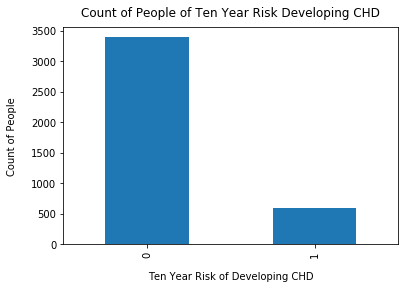

In [22]:
# Visualize the data
# Visualize the target variable. (Data imbalance)
import matplotlib.pyplot as plt
heart1['TenYearCHD'].value_counts().plot(kind='bar')
plt.xlabel("Ten Year Risk of Developing CHD", labelpad=14)
plt.ylabel("Count of People", labelpad=14)
plt.title("Count of People of Ten Year Risk Developing CHD", y=1.02);

In [23]:
# Visualzie the data
## Plot the Correlation Plot
dat = heart1[["totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]].values.T
dat

array([[178.  , 311.  , 266.  , ..., 207.  , 210.  , 269.  ],
       [160.  , 206.  , 114.  , ..., 126.5 , 126.5 , 133.5 ],
       [ 98.  ,  92.  ,  76.  , ...,  80.  ,  87.  ,  83.  ],
       [ 40.11,  21.51,  17.61, ...,  19.71,  19.16,  21.47],
       [ 75.  ,  76.  ,  88.  , ...,  65.  ,  86.  ,  80.  ],
       [225.  , 215.  ,  55.  , ...,  68.  ,  79.  , 107.  ]])

In [24]:
## Getting insurance numeric variables correlation info
corrMatrix = np.corrcoef(dat)
corrMatrix

array([[1.        , 0.21472562, 0.17205729, 0.12296341, 0.08837056,
        0.04672073],
       [0.21472562, 1.        , 0.78556319, 0.3297192 , 0.18716477,
        0.13140752],
       [0.17205729, 0.78556319, 1.        , 0.38351541, 0.18209773,
        0.06306085],
       [0.12296341, 0.3297192 , 0.38351541, 1.        , 0.07358042,
        0.07876881],
       [0.08837056, 0.18716477, 0.18209773, 0.07358042, 1.        ,
        0.08791722],
       [0.04672073, 0.13140752, 0.06306085, 0.07876881, 0.08791722,
        1.        ]])

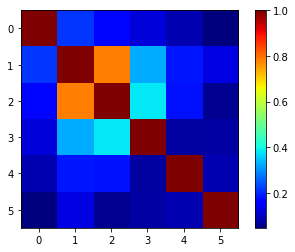

In [25]:
plt.imshow(corrMatrix, cmap='jet')
plt.colorbar()
# high correlation between sysBP and diaBP which is make sense.

In [26]:
## Split the dataset to Train and Test set
## Balance the target categorical variable

# Splitting the data
# Separate input features and output feature
X = heart1.drop(columns = ['TenYearCHD'])       # input features
Y = heart1.TenYearCHD      # output feature

In [27]:
## Split the dataset to Train and Test

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [28]:
# 'resample' is located under sklearn.utils
from sklearn.utils import resample

# concatenate training data back together
train_data = pd.concat([X_train, Y_train], axis = 1)

In [29]:
# separate minority and majority class
not_risk = train_data[train_data.TenYearCHD==0]
risk = train_data[train_data.TenYearCHD==1]

# Unsample minority; we are oversampling the minority class to match the number of majority classs
risk_upsampled = resample(risk,
                           replace = True, # Sample with replacement
                           n_samples = len(not_risk), # Match number in majority class
                           random_state=27)

# combine majority and upsampled minority
upsampled = pd.concat([not_risk, risk_upsampled])

# Now let's check the classes count
upsampled.TenYearCHD.value_counts()

1    2388
0    2388
Name: TenYearCHD, dtype: int64

In [30]:
# Splitting the data
# Separate input features and output feature
X1 = upsampled.drop(columns = ['TenYearCHD'])       # input features
Y1 = upsampled.TenYearCHD      # output feature

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = 0.3, random_state = 42)

In [31]:
## Resample the data by SMOTE
## Split the dataset to Train and Test set
## Balance the target categorical variable

#X = heart1.loc[:, heart1.columns != 'TenYearCHD']
#y = heart1.loc[:, heart1.columns == 'TenYearCHD']

#os = SMOTE()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#columns = X_train.columns
#os_data_X,os_data_y=os.fit_resample(X_train, y_train)
#os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
#os_data_y= pd.DataFrame(data=os_data_y,columns=['TenYearCHD'])

# we can Check the numbers of our data
#print("length of oversampled data is ",len(os_data_X))
#print("Number of TenYearCHD = 0 in oversampled data",len(os_data_y[os_data_y['TenYearCHD']==0]))
#print("Number of TenYearCHD = 1",len(os_data_y[os_data_y['TenYearCHD']==1]))
#print("Proportion of TenYearCHD = 0 in oversampled data is ",len(os_data_y[os_data_y['TenYearCHD']==0])/len(os_data_X))
#print("Proportion of TenYearCHD = 1 in oversampled data is ",len(os_data_y[os_data_y['TenYearCHD']==1])/len(os_data_X))

In [32]:
#### Statiscal Modelling
## Perform Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

LRModel = LogisticRegression()
LRModel.fit(X1_train, Y1_train)

C:\Users\ngsook\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [46]:
predTrain = LRModel.predict(X1_train)
predTest = LRModel.predict(X1_test)
trainAccuracy = np.mean(predTrain == Y1_train)
testAccuracy = np.mean(predTest == Y1_test)

print ('Training Accuracy Percentage =', trainAccuracy*100)
print ('Testing Accuracy Percentage =', testAccuracy*100)

Training Accuracy Percentage = 66.76637750523481
Testing Accuracy Percentage = 67.4808094905792


C:\Users\ngsook\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\ngsook\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [47]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(Y1_test, predTest)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[624 109]
 [ 26 674]]

True Positives(TP) =  624

True Negatives(TN) =  674

False Positives(FP) =  109

False Negatives(FN) =  26


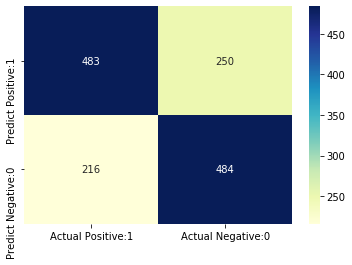

In [48]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm1, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [38]:
# Try Machine Learning Method
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X1_train, Y1_train)

LGBMClassifier()

In [40]:
y_pred=clf.predict(X1_test)

In [42]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, Y1_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y1_test, y_pred)))

LightGBM Model accuracy score: 0.9058


In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y1_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[624 109]
 [ 26 674]]

True Positives(TP) =  624

True Negatives(TN) =  674

False Positives(FP) =  109

False Negatives(FN) =  26


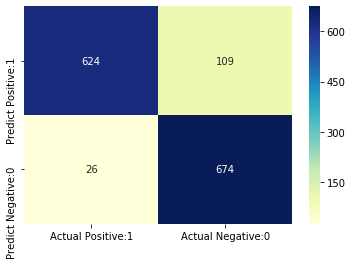

In [45]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')